In [1]:
# (Run only if you don't have torch) - in Jupyter you can run !pip install ...
# !pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F   # useful functional ops like relu, softmax
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

# device: will use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# reproducibility (helps when you experiment)
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)


Using device: cpu


Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:07<00:00, 1250475.33it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 37296.74it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:02<00:00, 615565.07it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 3778367.47it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



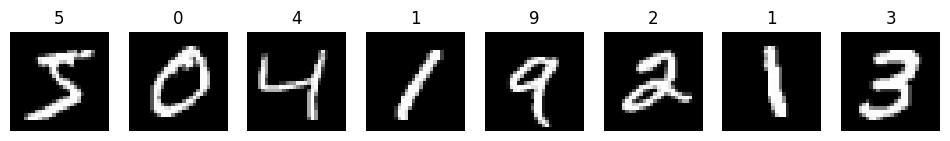

In [2]:
# normalization values are common for MNIST: mean ~0.1307, std ~0.3081
transform = transforms.Compose([
    transforms.ToTensor(),                      # uint8 0-255 -> float [0,1], shape (C,H,W)
    transforms.Normalize((0.1307,), (0.3081,))  # normalize each channel
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# quick peek: first 8 images
fig, axes = plt.subplots(1, 8, figsize=(12,3))
for i in range(8):
    img, label = train_dataset[i]
    img = img.squeeze(0)  # from (1,28,28) -> (28,28)
    # denormalize for display (undo normalize)
    img = img * 0.3081 + 0.1307
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(label))
plt.show()


In [3]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)

# quick sanity: inspect one batch's shapes
data_iter = iter(train_loader)
images, labels = next(data_iter)
print("images.shape:", images.shape)   # (batch_size, 1, 28, 28)
print("labels.shape:", labels.shape)   # (batch_size,)


images.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])


In [4]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # input size 28*28 = 784
        self.fc1 = nn.Linear(28*28, 256)  # first hidden layer
        self.fc2 = nn.Linear(256, 64)     # second hidden layer
        self.fc3 = nn.Linear(64, 10)      # output: 10 classes (digits 0-9)
        self.dropout = nn.Dropout(0.2)    # regularization

    def forward(self, x):
        # x comes in as (batch, 1, 28, 28). Flatten to (batch, 784)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))   # hidden activation
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)           # final layer -- returns raw scores (logits)
        return x

model = SimpleMLP().to(device)
print(model)


SimpleMLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [5]:
criterion = nn.CrossEntropyLoss()           # combines LogSoftmax + NLLLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [6]:
def train_one_epoch(model, device, train_loader, optimizer, criterion, epoch):
    model.train()       # sets dropout, batchnorm to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()           # reset gradients from previous step
        outputs = model(data)           # forward pass -> logits
        loss = criterion(outputs, target)
        loss.backward()                 # compute gradients (backprop)
        optimizer.step()                # update parameters

        running_loss += loss.item() * data.size(0)  # accumulate loss (per sample)
        _, preds = outputs.max(1)       # predicted class = argmax over logits
        correct += preds.eq(target).sum().item()
        total += target.size(0)

        # optional: print progress every 200 batches
        if batch_idx % 200 == 0:
            print(f"Epoch {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}]  Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    print(f"Epoch {epoch} TRAIN Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")


In [7]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, target).item() * data.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    print(f"TEST  Loss: {test_loss:.4f}  Acc: {correct}/{len(test_loader.dataset)} ({100.*test_acc:.2f}%)")
    return test_loss, test_acc


In [8]:
n_epochs = 5
for epoch in range(1, n_epochs+1):
    train_one_epoch(model, device, train_loader, optimizer, criterion, epoch)
    evaluate(model, device, test_loader, criterion)


Epoch 1 [12800/60000]  Loss: 0.3577
Epoch 1 [25600/60000]  Loss: 0.2952
Epoch 1 [38400/60000]  Loss: 0.1853
Epoch 1 [51200/60000]  Loss: 0.0176
Epoch 1 TRAIN Loss: 0.2678  Acc: 0.9187
TEST  Loss: 0.1236  Acc: 9618/10000 (96.18%)
Epoch 2 [12800/60000]  Loss: 0.0587
Epoch 2 [25600/60000]  Loss: 0.1185
Epoch 2 [38400/60000]  Loss: 0.1741
Epoch 2 [51200/60000]  Loss: 0.0992
Epoch 2 TRAIN Loss: 0.1198  Acc: 0.9630
TEST  Loss: 0.1133  Acc: 9635/10000 (96.35%)
Epoch 3 [12800/60000]  Loss: 0.0876
Epoch 3 [25600/60000]  Loss: 0.0626
Epoch 3 [38400/60000]  Loss: 0.1464
Epoch 3 [51200/60000]  Loss: 0.0537
Epoch 3 TRAIN Loss: 0.0915  Acc: 0.9716
TEST  Loss: 0.0795  Acc: 9755/10000 (97.55%)
Epoch 4 [12800/60000]  Loss: 0.0374
Epoch 4 [25600/60000]  Loss: 0.0136
Epoch 4 [38400/60000]  Loss: 0.0709
Epoch 4 [51200/60000]  Loss: 0.0438
Epoch 4 TRAIN Loss: 0.0754  Acc: 0.9760
TEST  Loss: 0.0785  Acc: 9757/10000 (97.57%)
Epoch 5 [12800/60000]  Loss: 0.0147
Epoch 5 [25600/60000]  Loss: 0.0087
Epoch 5 [384

In [9]:
torch.save(model.state_dict(), "mnist_mlp.pth")